Goal
Implement a pure session-based KNN baseline and evaluate it on MARS using the exact same evaluation protocol we validated in 06.
Session-KNN here means:
- represent a session by its recent items
- retrieve similar past sessions from training data
- score items by similarity-weighted frequency

In [1]:
# Quick (unsafe) workaround to avoid the libiomp5md.dll crash.
# Use this only to continue working in the notebook quickly.
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print("Set KMP_DUPLICATE_LIB_OK=TRUE — restart kernel and re-run cells now.")

Set KMP_DUPLICATE_LIB_OK=TRUE — restart kernel and re-run cells now.


Imports & run header

In [2]:
# CELL [07-01] — Imports & run header

import json
from pathlib import Path
from collections import defaultdict, Counter
import math

import torch
from torch.utils.data import DataLoader

print("[07-01] Starting 07_session_knn_baseline.ipynb")
print("[07-01] torch:", torch.__version__)


[07-01] Starting 07_session_knn_baseline.ipynb
[07-01] torch: 2.5.1


Paths, device, load metadata

In [3]:
# CELL [07-02] — Config & metadata

DATA_DIR = Path("../data/processed")
SHARDS_DIR = DATA_DIR / "tensor_shards_v2"
META_PATH = SHARDS_DIR / "metadata.json"

assert META_PATH.exists(), "[07-02] metadata.json not found"

with open(META_PATH, "r") as f:
    meta = json.load(f)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MAX_PREFIX_LEN = meta["max_prefix_len"]
PAD_ID = meta["pad_id"]
UNK_ID = meta["unk_id"]
TARGET_VOCAB_SIZE = meta["vocab"]["target"]["size"]

print("[07-02] DEVICE:", DEVICE)
print("[07-02] TARGET_VOCAB_SIZE:", TARGET_VOCAB_SIZE)


[07-02] DEVICE: cuda
[07-02] TARGET_VOCAB_SIZE: 702


Import loaders & metrics from 06

In [4]:
# CELL [07-03] — Import from 06 notebook (assumed executed)

# Required objects from 06:
# - make_loader
# - recall_at_k
# - mrr_at_k

print("[07-03] Using DataLoader & metrics from 06")


[07-03] Using DataLoader & metrics from 06


[07-03A] — Re-define loader utilities (from 06)

In [6]:
# CELL [07-03A] — Loader utilities (copied from 06 for self-containment)

from torch.utils.data import IterableDataset, DataLoader

def list_shards(domain: str, split: str):
    pattern = f"{domain}_{split}_shard_*.pt"
    return sorted(SHARDS_DIR.glob(pattern))

class ShardExamplesDataset(IterableDataset):
    def __init__(self, shard_paths, shuffle_shards=False):
        self.shard_paths = list(shard_paths)
        self.shuffle_shards = shuffle_shards

    def __iter__(self):
        paths = self.shard_paths
        for sp in paths:
            shard = torch.load(sp, map_location="cpu", weights_only=True)
            n = shard["input_ids"].shape[0]
            for i in range(n):
                yield {
                    "input_ids": shard["input_ids"][i],
                    "attention_mask": shard["attention_mask"][i],
                    "pos_ids": shard["pos_ids"][i],
                    "labels": shard["labels"][i],
                    "lengths": shard["lengths"][i],
                }

def collate_batch(batch):
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch]),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch]),
        "pos_ids": torch.stack([x["pos_ids"] for x in batch]),
        "labels": torch.stack([x["labels"] for x in batch]),
        "lengths": torch.stack([x["lengths"] for x in batch]),
    }

def make_loader(domain, split, batch_size, shuffle_shards=False):
    shard_paths = list_shards(domain, split)
    assert len(shard_paths) > 0, f"No shards for {domain}/{split}"

    ds = ShardExamplesDataset(shard_paths, shuffle_shards)
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0,
        collate_fn=collate_batch,
        drop_last=False
    )
    print(f"[07-03A] Loader ready: {domain}/{split}, shards={len(shard_paths)}")
    return loader


Build session representations from TRAIN data

We build an item → sessions inverted index from MARS TRAIN only
(no leakage into val/test).

In [7]:
# CELL [07-04] — Build session representations (MARS TRAIN)

mars_train_loader = make_loader(
    domain="mars",
    split="train",
    batch_size=512,
    shuffle_shards=False
)

# Store sessions as sets of items
train_sessions = []
item_to_sessions = defaultdict(set)

session_id = 0

for batch in mars_train_loader:
    input_ids = batch["input_ids"]
    lengths = batch["lengths"]

    for i in range(input_ids.size(0)):
        L = lengths[i].item()
        seq = input_ids[i, -L:].tolist()
        seq = [x for x in seq if x not in (PAD_ID, UNK_ID)]

        if len(seq) == 0:
            continue

        train_sessions.append(seq)

        for item in set(seq):
            item_to_sessions[item].add(session_id)

        session_id += 1

print("[07-04] Total train sessions:", len(train_sessions))
print("[07-04] Unique items in index:", len(item_to_sessions))


[07-03A] Loader ready: mars/train, shards=1
[07-04] Total train sessions: 1744
[07-04] Unique items in index: 649


Similarity function (cosine over binary vectors)

In [8]:
# CELL [07-05] — Session similarity

def cosine_sim(a: set, b: set) -> float:
    if not a or not b:
        return 0.0
    return len(a & b) / math.sqrt(len(a) * len(b))


Session-KNN scorer

For a query session:
- find candidate sessions sharing at least one item
- compute similarity
- aggregate scores for next items

In [9]:
# CELL [07-06] — Session-KNN scoring

def session_knn_score(
    query_seq,
    k_neighbors=100
):
    query_set = set(query_seq)
    candidate_sessions = set()

    for item in query_set:
        candidate_sessions |= item_to_sessions.get(item, set())

    sims = []
    for sid in candidate_sessions:
        sim = cosine_sim(query_set, set(train_sessions[sid]))
        if sim > 0:
            sims.append((sid, sim))

    sims.sort(key=lambda x: x[1], reverse=True)
    sims = sims[:k_neighbors]

    scores = Counter()
    for sid, sim in sims:
        for item in train_sessions[sid]:
            scores[item] += sim

    return scores


Metrics (Recall@K, MRR@K)

In [13]:
# CELL [07-06A] — Metrics (copied from 06 for self-containment)

@torch.no_grad()
def recall_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> float:
    """
    scores: [B, V]
    labels: [B]
    """
    topk = torch.topk(scores, k=k, dim=1).indices  # [B, k]
    hit = (topk == labels.unsqueeze(1)).any(dim=1).float()  # [B]
    return float(hit.mean().item())

@torch.no_grad()
def mrr_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> float:
    """
    Mean Reciprocal Rank at K.
    """
    topk = torch.topk(scores, k=k, dim=1).indices  # [B, k]
    labels_exp = labels.unsqueeze(1)               # [B, 1]
    match = (topk == labels_exp)                   # [B, k]

    ranks = torch.arange(1, k + 1, device=scores.device).unsqueeze(0)  # [1, k]
    rr = torch.where(match, 1.0 / ranks, torch.zeros_like(ranks, dtype=torch.float))
    rr_max = rr.max(dim=1).values  # [B]
    return float(rr_max.mean().item())


Convert scores → logits vector

In [14]:
# CELL [07-07] — Build logits tensor

def scores_to_logits(scores: Counter, vocab_size: int):
    logits = torch.zeros(vocab_size)
    for item, score in scores.items():
        if item < vocab_size:
            logits[item] = score
    return logits


Evaluation loop (Session-KNN on MARS)

In [15]:
# CELL [07-08] — Evaluate Session-KNN on MARS

def evaluate_session_knn(loader, k_eval=20, k_neighbors=100):
    recalls = []
    mrrs = []

    for bi, batch in enumerate(loader, 1):
        input_ids = batch["input_ids"]
        lengths = batch["lengths"]
        labels = batch["labels"]

        for i in range(input_ids.size(0)):
            L = lengths[i].item()
            query_seq = input_ids[i, -L:].tolist()
            query_seq = [x for x in query_seq if x not in (PAD_ID, UNK_ID)]

            scores = session_knn_score(query_seq, k_neighbors=k_neighbors)
            logits = scores_to_logits(scores, TARGET_VOCAB_SIZE).unsqueeze(0)

            label = labels[i].unsqueeze(0)

            recalls.append(recall_at_k(logits, label, k_eval))
            mrrs.append(mrr_at_k(logits, label, k_eval))

        if bi % 10 == 0:
            print(f"[07-08] batch {bi} processed")

    return {
        f"Recall@{k_eval}": sum(recalls) / len(recalls),
        f"MRR@{k_eval}": sum(mrrs) / len(mrrs),
        "num_examples": len(recalls)
    }


Run on MARS validation set

In [16]:
# CELL [07-09] — Run evaluation (MARS val)

mars_val_loader = make_loader(
    domain="mars",
    split="val",
    batch_size=64,
    shuffle_shards=False
)

metrics = evaluate_session_knn(
    mars_val_loader,
    k_eval=20,
    k_neighbors=100
)

print("[07-09] Session-KNN MARS validation metrics:")
print(metrics)


[07-03A] Loader ready: mars/val, shards=1
[07-09] Session-KNN MARS validation metrics:
{'Recall@20': 0.6312056737588653, 'MRR@20': 0.14455111511051655, 'num_examples': 282}


Save results

In [17]:
# CELL [07-10] — Save results

OUT_RESULTS = Path("../results")
OUT_RESULTS.mkdir(exist_ok=True)

out_path = OUT_RESULTS / "session_knn_mars_val.json"

with open(out_path, "w") as f:
    json.dump(metrics, f, indent=2)

print("[07-10] Results saved to:", out_path.resolve())


[07-10] Results saved to: D:\00_DS-ML-Workspace\session-transfer-mooc\results\session_knn_mars_val.json


Run Session-KNN on MARS test

In [18]:
# CELL [07-11] — Run evaluation (MARS test)

mars_test_loader = make_loader(
    domain="mars",
    split="test",
    batch_size=64,
    shuffle_shards=False
)

test_metrics = evaluate_session_knn(
    mars_test_loader,
    k_eval=20,
    k_neighbors=100
)

print("[07-11] Session-KNN MARS test metrics:")
print(test_metrics)


[07-03A] Loader ready: mars/test, shards=1
[07-11] Session-KNN MARS test metrics:
{'Recall@20': 0.6815642458100558, 'MRR@20': 0.141597027968428, 'num_examples': 358}


Save test results

In [19]:
# CELL [07-12] — Save MARS test results

out_path = OUT_RESULTS / "session_knn_mars_test.json"

with open(out_path, "w") as f:
    json.dump(test_metrics, f, indent=2)

print("[07-12] Test results saved to:", out_path.resolve())


[07-12] Test results saved to: D:\00_DS-ML-Workspace\session-transfer-mooc\results\session_knn_mars_test.json


Load saved results + build metrics table

In [20]:
# CELL [07-13] — Load results + summary table (VAL vs TEST)

import pandas as pd
import json
from pathlib import Path

RESULTS_DIR = Path("../results")
val_path = RESULTS_DIR / "session_knn_mars_val.json"
test_path = RESULTS_DIR / "session_knn_mars_test.json"

assert val_path.exists(), f"[07-13] Missing: {val_path}"
assert test_path.exists(), f"[07-13] Missing: {test_path}"

val_metrics = json.load(open(val_path, "r"))
test_metrics = json.load(open(test_path, "r"))

df_metrics = pd.DataFrame([
    {"split": "val", **val_metrics},
    {"split": "test", **test_metrics},
]).set_index("split")

print("[07-13] Loaded metrics:")
display(df_metrics)


[07-13] Loaded metrics:


,Recall@20,MRR@20,num_examples
split,,,
val,0.631206,0.144551,282
test,0.681564,0.141597,358


Plot: Recall@20 and MRR@20 (val vs test)

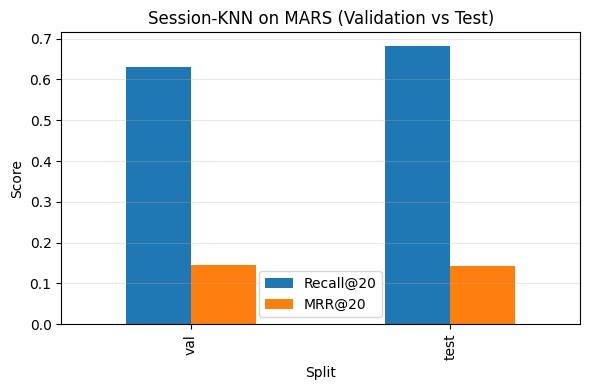

In [21]:
# CELL [07-14] — Plot baseline metrics (VAL vs TEST)

import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(6, 4))
ax1 = fig1.add_subplot(111)
df_metrics[["Recall@20", "MRR@20"]].plot(kind="bar", ax=ax1)
ax1.set_title("Session-KNN on MARS (Validation vs Test)")
ax1.set_xlabel("Split")
ax1.set_ylabel("Score")
ax1.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


Build index diagnostics table (real)

This summarizes what we actually indexed in [07-04] (1744 train examples, 649 unique items).

In [22]:
# CELL [07-15] — Index diagnostics table (real)

# train_sessions was built in [07-04]
assert "train_sessions" in globals(), "[07-15] train_sessions not found. Run [07-04] first."
assert "item_to_sessions" in globals(), "[07-15] item_to_sessions not found. Run [07-04] first."

session_lengths = [len(s) for s in train_sessions]

diag = {
    "mars_train_examples_indexed": len(train_sessions),
    "unique_items_in_index": len(item_to_sessions),
    "avg_items_per_session": float(sum(session_lengths) / max(len(session_lengths), 1)),
    "median_items_per_session": float(pd.Series(session_lengths).median()),
    "min_items_per_session": int(min(session_lengths)) if session_lengths else 0,
    "max_items_per_session": int(max(session_lengths)) if session_lengths else 0,
}

df_diag = pd.DataFrame([diag]).T
df_diag.columns = ["value"]

print("[07-15] Session-KNN index diagnostics:")
display(df_diag)


[07-15] Session-KNN index diagnostics:


,value
mars_train_examples_indexed,1744.000000
unique_items_in_index,649.000000
avg_items_per_session,6.838876
median_items_per_session,4.000000
min_items_per_session,1.000000
max_items_per_session,20.000000


Plot: session length distribution (MARS train prefixes)

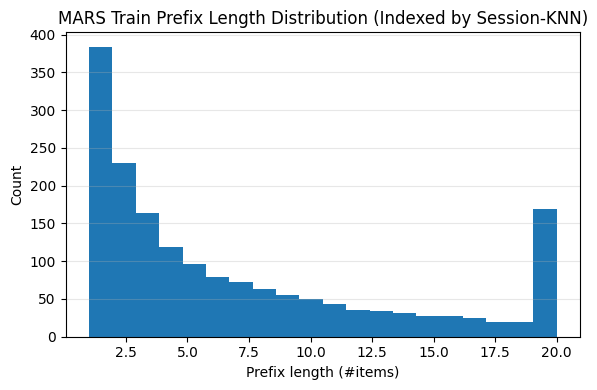

[07-16] Count: 1744 | mean: 6.838876146788991 | min: 1 | max: 20


In [23]:
# CELL [07-16] — Plot session length distribution (MARS train)

import matplotlib.pyplot as plt

fig2 = plt.figure(figsize=(6, 4))
ax2 = fig2.add_subplot(111)

ax2.hist(session_lengths, bins=20)
ax2.set_title("MARS Train Prefix Length Distribution (Indexed by Session-KNN)")
ax2.set_xlabel("Prefix length (#items)")
ax2.set_ylabel("Count")
ax2.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("[07-16] Count:", len(session_lengths),
      "| mean:", sum(session_lengths)/max(len(session_lengths),1),
      "| min:", min(session_lengths) if session_lengths else None,
      "| max:", max(session_lengths) if session_lengths else None)


Session-KNN Baseline on MARS — Short Report

Setup.
Session-KNN was trained using MARS train only (1,744 prefix sessions, 649 unique items) and evaluated on validation and test splits under the unified Recall@20 / MRR@20 protocol.

Results.

Validation: Recall@20 = 0.6312, MRR@20 = 0.1446 (282 examples)

Test: Recall@20 = 0.6816, MRR@20 = 0.1416 (358 examples)

The strong Recall@20 indicates that neighborhood-based methods are highly effective in this small MOOC setting, while MRR@20 shows moderate ranking quality—expected given sparse and short sessions.

Session characteristics.

Average prefix length: 6.84 items (median = 4)

Prefix lengths are right-skewed, with many very short sessions (1–3 items) and a capped maximum of 20.
This explains why Session-KNN performs well: short sessions benefit from overlap-based retrieval, especially when item reuse is high.

Interpretation.
These results establish a strong non-neural baseline. Any neural or transfer/meta-learning model must clearly surpass Recall@20 ≈ 0.68 on test or significantly improve MRR to justify added complexity.

This baseline is now locked and will be used as the primary reference point for GRU4Rec, NARM, and SASRecSmall.